In [168]:
%matplotlib inline
from matplotlib.pyplot import plot, show, figure, title
import matplotlib.pyplot as plt
import numpy as np

from scipy.fftpack import dct, idct
from scipy.io import wavfile

# This notebook tries to demonstrate the power of random projections with music, since we can observe it directly. I will skip a lot of math since the focus should be on the demonstration. All the theory can be found in the lecture notes and when needed, I linked additional resources.

---



# We start by defining our signal. We use an addition of simple sine waves.

General settings. Don't change them.

In [169]:
# Fs defines the sampling rate of one would normally use.
# 44.1kHz is a usual sample rate for consumer audio files like mp3
Fs = 44100  

# the duration of the sample in seconds
# note that it should not really exceed more than one second
# since this means an input vector of 44100 values and can fill
# your RAM very quick.
#
# furthermore the signal can be observed better in a short
# period of time
duration = 0.5

# this automatically defines out number of samples and
# the generates a time array
n_samp = int(Fs*duration)
t = np.linspace(0,duration, n_samp)

Now define the frequencies you want the signal to consist of.

In [170]:
freqs = [420, 500, 1300]

# automatically generate the signal by addition of sines
signal = np.sum([np.sin(2*np.pi*t*f) for f in freqs], axis=0)

Plotting the signal

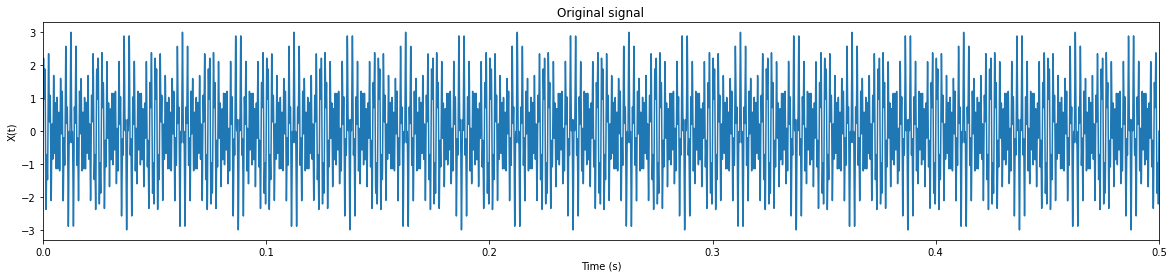

In [171]:
figure(figsize=[20,4])
plot(t,signal)
title('Original signal')
plt.xlabel('Time (s)')
plt.ylabel('X(t)')
plt.xlim([0,duration])
plt.show()

In [172]:
# if you want you can save the original signal as wav file and listen to it
wavfile.write('original.wav',Fs, signal)

Now let's go a bit into theory. Normally you would sample the signal at the Nyquist frequency which is defined as $$f_{nyquist} = 2 * f_0$$ where $f_0$ is the bandwidth of your signal. Since human hearing is know to be in the range from $20$ Hz to $20$ kHz we only need to cover a bandwidth of $20$ kHz. Now multiply by $2$ and we come to the $40$ kHz. So for lossless sampling of our defined signal in the hearing bandwith of humans, we need to sample it at 40 kHz which is taking a sample at each $1/40000 = 0.000025 s$.

Now we learned in the chapter of compressive sensing, that it can be possible to randomly sample the signal with length p and only take m samples with $$m < p.$$

The signal would then be represented by $$
\begin{equation}
\begin{bmatrix}
\\ y \\ \\
\end{bmatrix}
=
\begin{bmatrix}
\ \ \ A \ \ \ 
\end{bmatrix}
\begin{bmatrix}
\\ x \\ \\
\end{bmatrix}
\end{equation}
$$

where y $\in ℂ^{m}$, A $\in ℂ^{mxp}$ and x $\in ℂ^{p}$ [Eq. 10.1].
One thing to overcome is to represent the signal in a basis which is s-spare to apply Gordon's theorem. For music signals this can be the Fourier-Base. For the demonstration we use the cosine tranformation which represents our signal as a sum of cosines where our signal is found to be s-sparse,

$$
X_k = \sum_{n=0}^{N-1} x_n \cos \left[\frac{\pi}{N} \left(n+\frac{1}{2}\right) k \right] \quad \quad k = 0, \dots, N-1.
$$

So now let's transform the signal into the base where it is sparse.




In [173]:
# define the width of our matrix A which is equals to the number
# samples we want to take. Remeber that by Shannon this would
# be 40'000 to cover human hearing!
m = 1000

# with this number we take m random sample points
y = np.random.randint(0,n_samp,m)

# if you want to see what happens when we just take the same number of samples 
# but with an equal distribution, uncomment this y and comment the other one
# y = np.linspace(0,n_samp-1,m).astype(int)


# since we must index by ascending values,
# we have to sort the values
y = np.sort(y)

# now sample only m-times at random positions
Y = signal[y]

Let's have a look at the sample points.

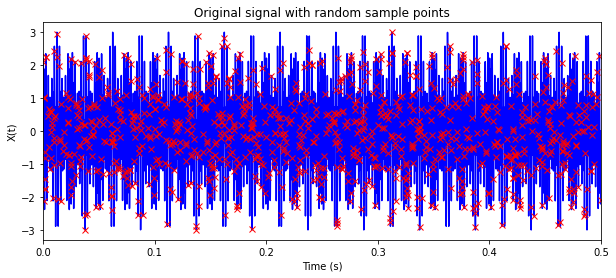

In [185]:
figure(figsize=[10,4])
plot(t,signal,'b',t[y],Y,'rx')
title('Original signal with random sample points')
plt.xlabel('Time (s)')
plt.ylabel('X(t)')
plt.xlim([0,duration])
plt.show()

The samples are not yet represented sparse. For this we have to define the base functions for the discrete cosine transform with the help of a library. Since the sample times are random, we have to build all the possible components and then chose the ones which correspond to our random samples. This method is also somewhat described in Chapter 10.3.

In [175]:
# construct the DCT basis functions
# this can take quite a while depending on the
# duration you chose
DCT = dct(np.eye(n_samp))
# take the same random samples from the base as from the signal
A = DCT[y]
print("The shape corresponds to m =", A.shape[0], " and p =", A.shape[1])               

The shape corresponds to m = 1000  and p = 22050


Now we need to solve the underteremined system knowing that our signal is sparse. It follows from Equation 10.2 that this approach corresponds to solving
$$ min || z||_0 \text{ such that } Az=y.$$
As written in the lecture notes, this problem is in general NP-hard and normally the following optimization problem is considered, since the $l_1$ unit ball becomes very "pointy" in high dimensions, which reminds of the $l_0$ norm:
$$ min || z||_1 \text{ such that } Az=y.$$

In reality, the solution is very often solved via Lasso Regression, which focuses on a $l_1$ constraint. Read more about it on [This Paper](https://www.stat.cmu.edu/~ryantibs/statml/lectures/sparsity.pdf). The derivation of the dual formulation can be found in Chapture 10.3 of the lecture notes. By sacrificing the exact recovery and by considering a signal with noise $w$ one can write the measurement as
$$ y=Ax+w.$$
From this we can arrive to the practical formulation
$$ \min_{x} \frac{1}{2}||Ax - y||_2^2 + λ||x||_1$$
which corresponds to the Lasso Regression.

Note the two conditions written in the lecture note. The first one is already satisfied, as we already randomly selected the support. The non-zero entries of sign(x) seem to form a Steinhaus sequence by watching the distribution of the values, but I didn't try to prove it, it seems a bit strange since the signal is very deterministic. Maybe someone can try to elaborate this?

Anyways, back to the problem. The matrix $A$ is already given in reduced form where we know that x is sparse, as well as the signal which is denoted as $y$.
The vector $x$ corresponds to the sparse solution. We can use libraries like scikit-learn to find the corresponding solution.
 

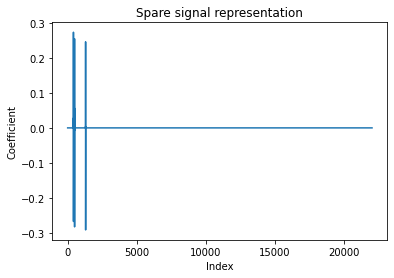

In [176]:
# the Lasso model solves the equation just described
# minimization problem for us.
# In sklearn the solution x is saved in the lasso coefficients
# the parameter alpha corresponds to lambda, which weights our l1 solution
# it is a hyperparameter which normally must be optimized for a given problem
from sklearn.linear_model import Lasso 
lasso = Lasso(alpha=0.1)
lasso.fit(A,Y)
x_sparse = lasso.coef_
plot(x_sparse)
title("Spare signal representation")
plt.ylabel("Coefficient")
plt.xlabel("Index")
plt.show()

Let's look at the sparsness of the vector and find the s value.

In [177]:
sparseness = np.sum(x_sparse== 0)/n_samp
print("Solution is %{} sparse".format(100.*sparseness))

Solution is %99.90476190476191 sparse


As you see this is a very sparse vector! We can directly print the nonzero values.

In [178]:
coefs = x_sparse[x_sparse != 0]
print("There are ", len(coefs), "nonzero entries in the vector. The vector looks as follows:")
print(coefs)

There are  21 nonzero entries in the vector. The vector looks as follows:
[ 0.0032618   0.01308616  0.02809738  0.06924185  0.27360751 -0.26769019
 -0.04293468  0.01311424  0.05655092  0.25490106 -0.28319716 -0.06603261
 -0.02389545 -0.00726422  0.00376893  0.04199739  0.24620634 -0.29190987
 -0.06480842 -0.01658647 -0.00299184]


Instead of taking 40000 samples we now have only around 30 (may change on the random choice) nonzero values after taking only m instead of p samples. For storage optimisation the coeficients could be saved with informationa about their index and the cosine base. Even with the additional information this is much less than saving 40000 values. But so how good can this be recovered? For recovery we do an inverse cosine transform on the sparse vector.

In [179]:
Xhat = idct(x_sparse)

Let's plot the reconstructed signal.

Text(0.5, 1.0, 'Differense of the original and the reconstruction')

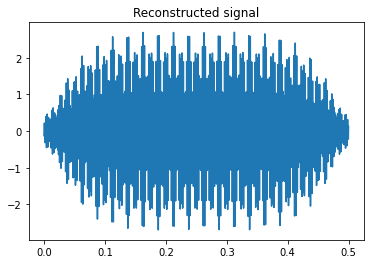

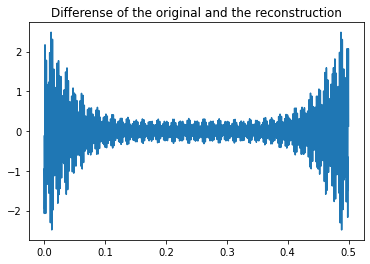

In [180]:
figure()
plot(t,Xhat)
title('Reconstructed signal')
figure()
plot(t,Xhat-signal)
title('Differense of the original and the reconstruction')

In [181]:
# If you want, save the reconstructed sound and listen to it.
wavfile.write('sound_reconstructed.wav',Fs, Xhat)

So as we see, the reconstruction is not perfect. Why is that?
At first let's qickly remember Gordon's theorem and that it suggests 
$$m≈s*log(\frac{s}{p})$$
being enough to recover x. You can quickly grab a calculator and compare the left and right side of the equation. Given that you didn't change the values the m is much larger than needed. But we aren't really solving the original optimization problem, but a relaxed one which is basically a least square regression with $l_1$ penalty and which even has a regularization parameter $\lambda$ to choose. Read more about it in the last chapters of the lecture note. So it is clear that we dind't really optimise the original problem. One good thing about sound is, that it's observation is quite subjective. Do you personally hear a difference? You can try changing the m and render different versions of the generated signals. You will observe that for some bigger m, which is still a lot smaller than p, one cannot hear a difference anymore.

Another problem is the discrete cosine transformation which can introduce aliasing and roundoff errors due to fixed point arithmetics. This actually is a much higher factor than m, since it appears that this fading stays even with very high m. It seems like this is a common problem of the Discrete Cosine Transform and is due to the fixed size windows which are used. Similar problems appear in DTFT. This is why modern audio compression techniques use[Modified discrete cosine transform](https://en.wikipedia.org/wiki/Modified_discrete_cosine_transform). So actually we can focus on just the inner part of the reconstructed signal and appreciate how well it worked!

Bonus:
I prepared taking sampling in equal distances. Just uncomment the corresponding line under the random function. Observe how the solution sparsity and the error changes.